In [235]:
# imported libraries
import numpy as np
from numpy import round
import math
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy.stats import norm
from scipy.stats import gaussian_kde
from scipy.stats import uniform
from scipy.integrate import quad

# Question 1

In [92]:
# load in our data
X = np.genfromtxt('Data/population_X.csv', delimiter=',')
Y = np.genfromtxt('Data/population_Y.csv', delimiter=',')
Z = np.genfromtxt('Data/population_Z.csv', delimiter=',')
Q = np.genfromtxt('Data/population_Q.csv', delimiter=',')
print(X.shape)
print(Y.shape)
print(Z.shape)
print(Q.shape)

(1000,)
(1000,)
(1000,)
(1000,)


### Part 1

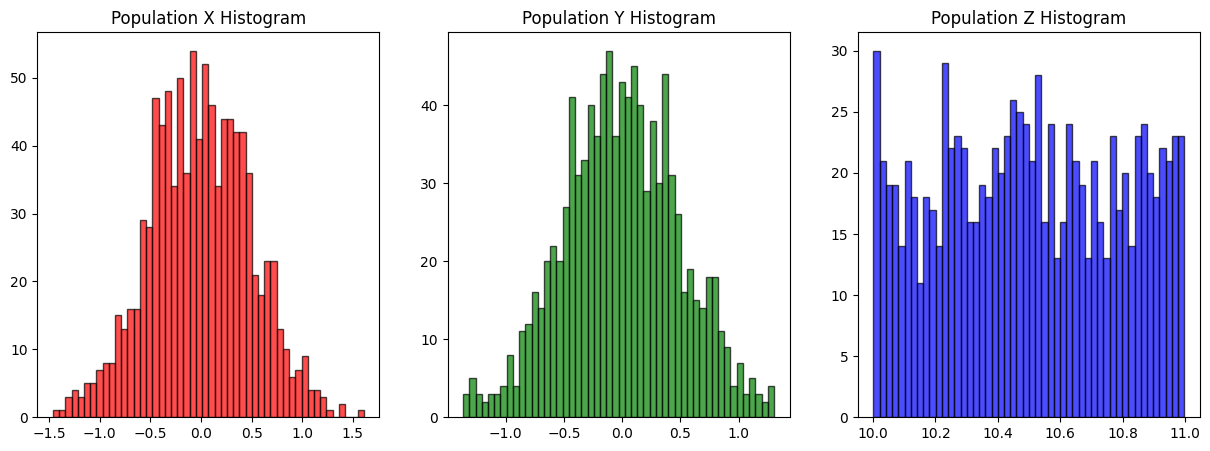

In [93]:
plt.figure(figsize=(15, 5))

# plotting population X
plt.subplot(1, 3, 1)
plt.hist(X, bins=50, color='red', alpha=0.7, edgecolor='black')
plt.title('Population X Histogram')

# plotting population Y
plt.subplot(1, 3, 2)
plt.hist(Y, bins=50, color='green', alpha=0.7, edgecolor='black')
plt.title('Population Y Histogram')

# plotting population Z
plt.subplot(1, 3, 3)
plt.hist(Z, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Population Z Histogram')

plt.show()

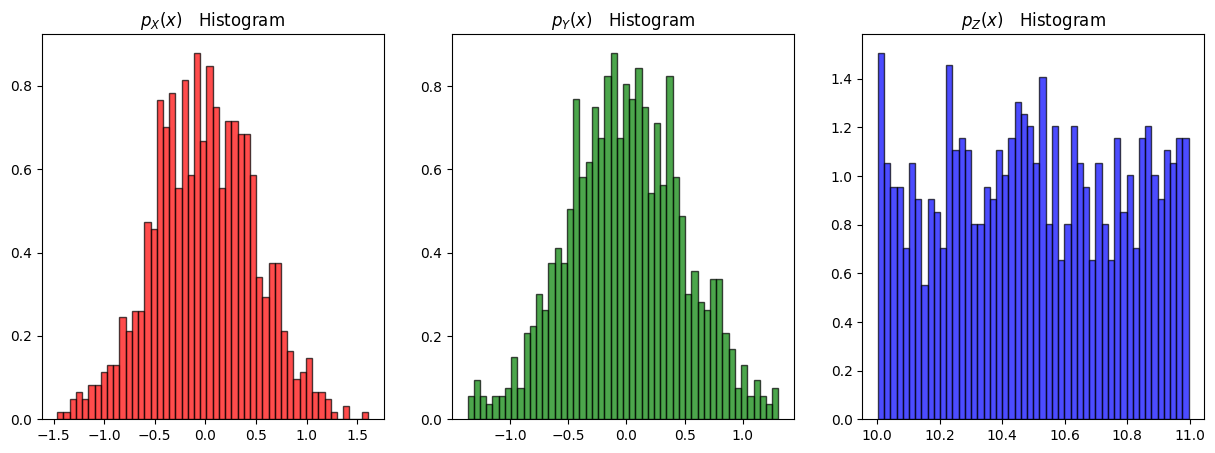

In [121]:
plt.figure(figsize=(15, 5))

# plotting PDF for population X
plt.subplot(1, 3, 1)
plt.hist(X, bins=50, color='red', alpha=0.7, edgecolor='black', density=True)
plt.title(r'$p_X(x) \quad$Histogram')

# plotting PDF for population Y
plt.subplot(1, 3, 2)
plt.hist(Y, bins=50, color='green', alpha=0.7, edgecolor='black', density=True)
plt.title(r'$p_Y(x) \quad$Histogram')

# plotting PDF for population Z
plt.subplot(1, 3, 3)
plt.hist(Z, bins=50, color='blue', alpha=0.7, edgecolor='black', density=True)
plt.title(r'$p_Z(x) \quad$Histogram')

plt.show()

### Part 2

When comparing the graphs, the histogram for population Y resembles the histogram for population X much more than population Z. Therefore, we choose population Y to be the population that likely cures disease over population Z.

### Part 3

A reasonable ε threshold value might be our $d_1$ value with a little more wiggle room. This is because we want to be rigorous in this process. Let's say we have population A. If the KL divergence of population A is the midpoint of $d_1$ and $d_2$, then it might be better than population Z, but might not be close enough to population X as we would like. The greater the ε, the more risk we are taking of accidentally killing people instead of curing disease. Therefore, we would like our population to be similar to population Y, which resembles the distribution of population X very well. 

For the sake of following the directions of the exam, we set our epsilon value to be the midpoint of $d_1$ and $d_2$ instead.

First let's define good pdf functions for each of the distributions

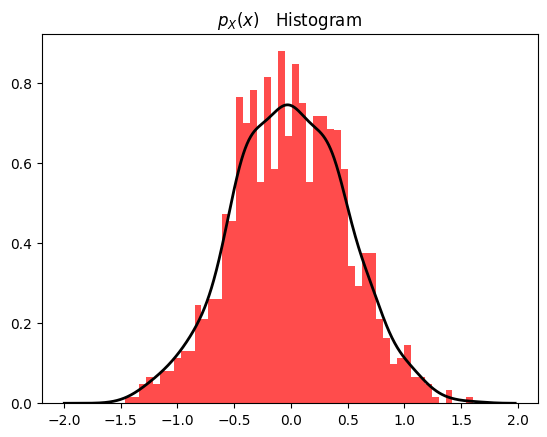

In [155]:
def p_X(x): 
	return gaussian_kde(X).evaluate(x)

plt.hist(X, bins=50, color='red', alpha=0.7, density=True)

x = np.linspace(np.mean(X)-4*np.std(X), np.mean(X)+4*np.std(X), 1000)
y = p_X(x)
plt.plot(x, y, color='black', linewidth=2)

plt.title(r'$p_X(x) \quad$Histogram')
plt.show()

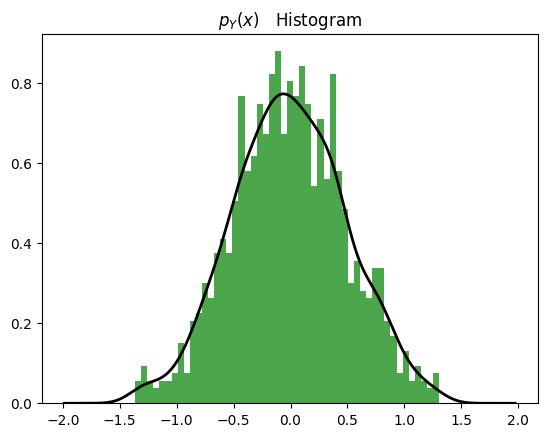

In [154]:
def p_Y(x): 
	return gaussian_kde(Y).evaluate(x)

plt.hist(Y, bins=50, color='green', alpha=0.7, density=True)

x = np.linspace(np.mean(Y)-4*np.std(Y), np.mean(Y)+4*np.std(Y), 1000)
y = p_Y(x)
plt.plot(x, y, color='black', linewidth=2)

plt.title(r'$p_Y(x) \quad$Histogram')
plt.show()

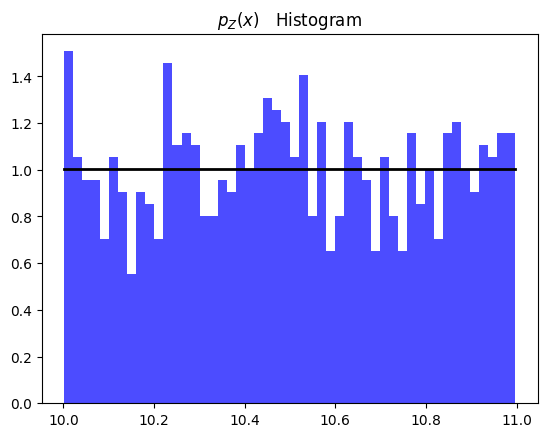

In [211]:
def p_Z(x): 
	loc = np.min(Z)
	scale = np.max(Z) - loc
	uniform_dist = uniform(loc=loc, scale=scale)
	return uniform_dist.pdf(x)

plt.hist(Z, bins=50, color='blue', alpha=0.7, density=True)

x = np.linspace(np.min(Z), np.max(Z), 1000)
y = p_Z(x)
plt.plot(x, y, color='black', linewidth=2)

plt.title(r'$p_Z(x) \quad$Histogram')
plt.show()

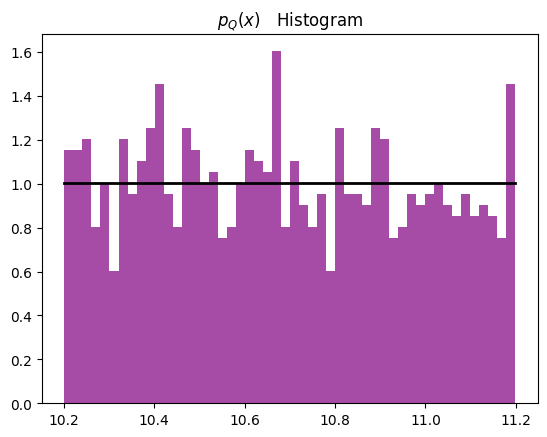

In [212]:
def p_Q(x): 
	loc = np.min(Q)
	scale = np.max(Q) - loc
	uniform_dist = uniform(loc=loc, scale=scale)
	return uniform_dist.pdf(x)

plt.hist(Q, bins=50, color='purple', alpha=0.7, density=True)

x = np.linspace(min(Q), max(Q), 1000)
y = p_Q(x)
plt.plot(x, y, color='black', linewidth=2)

plt.title(r'$p_Q(x) \quad$Histogram')
plt.show()

In [213]:
def KL_Divergence(p, q, min, max):
    def integrand(x):
        p_x = p(x)
        q_x = q(x)
        p_x = np.clip(p_x, 1e-10, None)
        q_x = np.clip(q_x, 1e-10, None)
        return p_x * np.log(p_x / q_x)
    kl, _ = quad(integrand, min, max)
    return kl

In [214]:
XY_KL = KL_Divergence(p_X, p_Y, np.min(np.concatenate([X, Y])), np.max(np.concatenate([X, Y])))
XZ_KL = KL_Divergence(p_X, p_Z, np.min(np.concatenate([X, Z])), np.max(np.concatenate([X, Z])))
print('KL Divergence between populations X and Y: ', XY_KL)
print('KL Divergence between populations X and Z: ', XZ_KL)
ε = (XY_KL + XZ_KL) / 2
print('Epsilon Value: ', ε)

KL Divergence between populations X and Y:  0.0015901294562248704
KL Divergence between populations X and Z:  22.25669808766444
Epsilon Value:  11.129144108560332


In [215]:
def KL_Divergence_sampling(p, q, samples):
    p_sample = np.clip(p(samples), 1e-10, None)
    q_sample = np.clip(q(samples), 1e-10, None)
    kl = np.mean(np.log(p_sample / q_sample))
    return kl

In [216]:
samples = gaussian_kde(X).resample(1000)
XY_KL_sample = KL_Divergence_sampling(p_X, p_Y, samples)
XZ_KL_sample = KL_Divergence_sampling(p_X, p_Z, samples)

print('KL Divergence between populations X and Y using sampling: ', XY_KL_sample)
print('KL Divergence between populations X and Z using sampling: ', XZ_KL_sample)
ε = (XY_KL_sample + XZ_KL_sample) / 2
print('Epsilon Value: ', ε)

KL Divergence between populations X and Y using sampling:  0.00654548801837151
KL Divergence between populations X and Z using sampling:  22.270539544710015
Epsilon Value:  11.138542516364193


In [239]:
XQ_KL = KL_Divergence(p_X, p_Q, np.min(np.concatenate([X, Q])), np.max(np.concatenate([X, Q])))
print('KL Divergence between populations X and Q: ', XQ_KL)

XQ_KL_sample = KL_Divergence_sampling(p_X, p_Q, samples)
print('KL Divergence between populations X and Q using sampling: ', XQ_KL_sample)

print()
print("Since these values are greater than our epsilon values, we reject Q.")

KL Divergence between populations X and Q:  22.25669808763363
KL Divergence between populations X and Q using sampling:  22.270539544710015

Since these values are greater than our epsilon values, we reject Q.


### Part 4

In [236]:
def p_Z_kde(x): 
	return gaussian_kde(Z).evaluate(x)

def p_Q_kde(x): 
	return gaussian_kde(Q).evaluate(x)

In [238]:
def H(p, lower, upper):
    # Define the integrand for differential entropy: -p(x)*log(p(x))
    integrand = lambda x: -p(x) * np.log(p(x))
    entropy, _ = quad(integrand, lower, upper)
    return entropy

X_entropy = H(p_X, min(X), max(X))
Y_entropy = H(p_Y, min(Y), max(Y))
Z_entropy = H(p_Z_kde, min(Z), max(Z))
Q_entropy = H(p_Q_kde, min(Q), max(Q))
print('Entropy of X:', X_entropy)
print('Entropy of Y:', Y_entropy)
print('Entropy of Z:', Z_entropy)
print('Entropy of Q:', Q_entropy)

Entropy of X: 0.7371030431807335
Entropy of Y: 0.7155050684412257
Entropy of Z: 0.049055421752763645
Entropy of Q: 0.04861291512177324


It looks like population Z is closest to population Q. So according to Grace's theory, Q belongs to Z. 

Whether Grace should get a raise or not is another question though. Since entropy measures uncertainty, it does not measure a variety of other factors that determine whether two distirbutions are similar. One distribution can have the same entropy as another, but wildly different values. Therefore, Grace can receive a small raise for giving us a factor in determining whether two distirbutions are similar, but we should not use her theory as the final call.

In [252]:
def H_sampling(p, samples):
    return -np.mean(np.log(p(samples)))

In [255]:
samples = gaussian_kde(X).resample(1000)
print(H_sampling(p_X, samples))

samples = gaussian_kde(Y).resample(1000)
print(H_sampling(p_Y, samples))

samples = gaussian_kde(Z).resample(1000)
print(H_sampling(p_Z_kde, samples))

samples = gaussian_kde(Q).resample(1000)
print(H_sampling(p_Q_kde, samples))

0.7504211748480263
0.7370398725037971
0.13964271700296227
0.15377385662505094


# Question 2

In [271]:
# load in the data
data = load_breast_cancer()
print(data['data'].shape)
print(data['target'].shape)

(569, 30)
(569,)


In [272]:
# train test split the data
X_train, X_rest, y_train, y_rest = train_test_split(data['data'], data['target'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

In [273]:
# preprocessing the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Part 1: KNN Algorithm

In [274]:
def KNN(query_point, data, labels, k):
    norms = []
    for i, point in enumerate(data):
        l2 = np.sqrt(np.sum((query_point - point) ** 2))
        norms.append([l2, labels[i]])
    
    norms.sort(key=lambda x: x[0])
    closest_points = []
    for i in range(k):
        closest_points.append(norms[i])
    
    label_count = {}
    for _, label in closest_points:
        if label in label_count:
            label_count[label] += 1
        else:
            label_count[label] = 1
    
    pred = max(label_count, key=label_count.get)
    
    return pred

In [275]:
for k in range(1, 20):
    correct = 0
    for i in range(X_val.shape[0]):
        pred = KNN(X_val[i], X_train, y_train, k)
        if pred == y_val[i]:
            correct += 1
    print('k='+str(k)+': '+str(correct/X_val.shape[0]))

k=1: 0.9122807017543859
k=2: 0.9122807017543859
k=3: 0.9122807017543859
k=4: 0.9122807017543859
k=5: 0.9122807017543859
k=6: 0.9122807017543859
k=7: 0.9122807017543859
k=8: 0.9122807017543859
k=9: 0.9298245614035088
k=10: 0.9298245614035088
k=11: 0.9122807017543859
k=12: 0.9122807017543859
k=13: 0.9122807017543859
k=14: 0.9122807017543859
k=15: 0.9122807017543859
k=16: 0.9122807017543859
k=17: 0.9122807017543859
k=18: 0.9122807017543859
k=19: 0.9122807017543859


Looking at our validation accuracy, it looks like the value of k does not have a large influence on KNN algorithm accuracy. I will choose a value of k=3, a seemingly reasonable k value, to use on our test dataset.

In [276]:
correct = 0
for i in range(X_test.shape[0]):
    pred = KNN(X_test[i], X_train, y_train, 3)
    if pred == y_test[i]:
        correct += 1
print('k='+str(3)+': '+str(correct/X_test.shape[0]))

k=3: 0.9824561403508771


### Part 2: Logistic Regression

In [277]:
w = np.ones_like(X_val[0])
Φ = X_train
n = X_train.shape[0]
y = y_train

In [278]:
def q(x=None, X=None, w=None):
	if X is None:
		return 1/(1 + np.exp(-x.T.dot(w)))
	else:
		return 1/(1 + np.exp(-X.dot(w)))

def dL(Φ, y, w):
	return Φ.T.dot(q(None, Φ, w) - y)/n

def gradient_descent(Φ, y, w, η):
	for i in range(2000):
		w = w - η*dL(Φ, y, w)
	return w

In [279]:
w = gradient_descent(Φ, y, w, 0.1)

preds = []
for x in X_val: 
    preds.append(round(q(x, None, w)))

correct = 0
for i in range(len(preds)):
    if y_val[i] == preds[i]:
        correct += 1

print("Validation accuracy: ", correct/len(y_val))

preds = []
for x in X_test: 
    preds.append(round(q(x, None, w)))

correct = 0
for i in range(len(preds)):
    if y_test[i] == preds[i]:
        correct += 1

print("Test accuracy: ", correct/len(y_test))

Validation accuracy:  0.9824561403508771
Test accuracy:  0.9824561403508771


### Part 3: SVM

In [296]:
w = np.ones_like(X_val[0])
η = 0.01

In [297]:
def dw(X, y, w):
	return 2*w - X.T.dot(y)

def GD(X, y, w):
	for i in range(100):
		w = w - η*dw(X,y,w)
	return w

In [298]:
w = GD(X_train, y_train, w)

In [328]:
norm_w = np.linalg.norm(w)
projections = X_train.dot(w) / norm_w
proj_1 = projections[y_train == 1]
proj_0 = projections[y_train == 0]
mid_point = (np.mean(proj_1) + np.mean(proj_0)) / 2
b = - mid_point * np.linalg.norm(w)

def classify(X, w, b):
    scores = X.dot(w) + b
    return np.where(scores >= 0, 1, 0)

pred = classify(X_test, w, b)

In [329]:
correct = 0
for i in range(len(pred)):
    if pred[i] == y_test[i]:
        correct += 1
print(correct/len(pred))

0.9824561403508771


Interestingly, when calculating the accuracy for all 3 of the algorithms on the test data, I got the same accuracy score. They all scored above 98%, a great accuracy. So accoridng to my results, all 3 algorithms would be a great choice.

# Question 3

In [85]:
exam = np.genfromtxt('Data/2024_Fall_exam1.csv', delimiter=',')
exam.shape

(144,)

### Part 1

λ: 6.5543923532089226


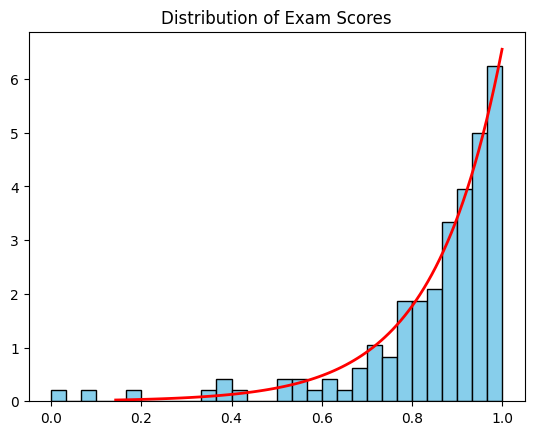

In [366]:
plt.hist(exam, bins=30, color='skyblue', edgecolor='black', density=True)

mean = np.mean(exam)
std = np.std(exam)
x = np.linspace(mean - 4 * std, 1, 100)
λ = 1 / (1 - np.mean(exam))
print('λ:', str(λ))
y = λ * np.exp(-λ*(1-x))
plt.plot(x, y, color='red', linewidth=2)

plt.title('Distribution of Exam Scores')
plt.show()

### Part 2: MLE

In [364]:
λ_MLE = 1
lr = 0.0001

for _ in range(20000):
    λ_MLE = λ_MLE - lr * (-np.sum((1 / λ_MLE) - (1 - exam)))

print('Optimal λ:', str(λ_MLE))

Optimal λ: 6.551477336456753


### Part 3

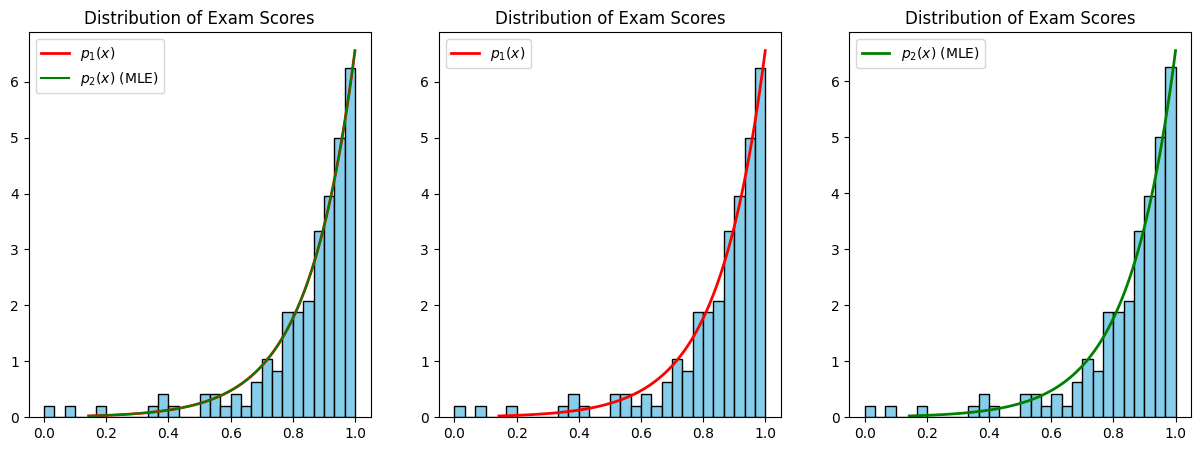

In [367]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)

plt.hist(exam, bins=30, color='skyblue', edgecolor='black', density=True)

mean = np.mean(exam)
std = np.std(exam)
x = np.linspace(mean - 4 * std, 1, 100)
y = λ * np.exp(λ*(x-1))
plt.plot(x, y, color='red', label='$p_1(x)$', linewidth=2)

y_MLE = λ_MLE * np.exp(λ_MLE*(x-1))
plt.plot(x, y_MLE, color='green', label='$p_2(x)$ (MLE)')

plt.legend()
plt.title('Distribution of Exam Scores')


plt.subplot(1, 3, 2)
plt.hist(exam, bins=30, color='skyblue', edgecolor='black', density=True)

mean = np.mean(exam)
std = np.std(exam)
x = np.linspace(mean - 4 * std, 1, 100)
y = λ * np.exp(λ*(x-1))
plt.plot(x, y, color='red', label='$p_1(x)$', linewidth=2)

plt.legend()
plt.title('Distribution of Exam Scores')


plt.subplot(1, 3, 3)

plt.hist(exam, bins=30, color='skyblue', edgecolor='black', density=True)

mean = np.mean(exam)
std = np.std(exam)
x = np.linspace(mean - 4 * std, 1, 100)
y_MLE = λ_MLE * np.exp(λ_MLE*(x-1))
plt.plot(x, y_MLE, color='green', label='$p_2(x)$ (MLE)', linewidth=2)

plt.legend()
plt.title('Distribution of Exam Scores')

plt.legend()
plt.title('Distribution of Exam Scores')
plt.show()

### Part 4

In [374]:
def p_exam(x):
    return λ_MLE * np.exp(λ_MLE*(x-1))

ans, _ = quad(p_exam, 0.88, 1)
print("Using our exponential model from doing MLE, around " + str(round(ans*100, 2)) + "% of students will get an A.")

Using our exponential model from doing MLE, around 54.44% of students will get an A.


In [376]:
samples = np.random.uniform(0.88, 1, 10000)
values = p_exam(samples)
ans= (1 - 0.88) * np.mean(values)
ans

0.5451415086310715